In [268]:
import requests
import pandas as pd
from tqdm import tqdm 
from bs4 import BeautifulSoup
import os
import mimetypes
import numpy as np
import os
import re
import googlemaps

# selenium method
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pyperclip

import time

# analysis
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# load environment file
from dotenv import load_dotenv

# duckdb
import duckdb
from collections import defaultdict


In [326]:
class DownloadFile:
    """Utility class for downloading files with progress and CER/ABS support."""

    def status_bar_api(self, api_url: str, csv_filename: str = None, status:str = None):
        """
        Download a file from API URL with progress bar.

        Args:
            api_url: Direct URL to download.
            csv_filename: Optional filename; if None, determined from URL or headers.
        """

        if status == 'api':
            with requests.get(api_url, stream=True) as response:
                response.raise_for_status()
                total_size = int(response.headers.get('content-length', 0))
                chunk_size = 1024 * 1024  # 1 MB chunks
                
                chunks = []
                with tqdm(total=total_size, unit='B', unit_scale=True, desc='Downloading') as pbar:
                    for chunk in response.iter_content(chunk_size=chunk_size):
                        if chunk:
                            chunks.append(chunk)
                            pbar.update(len(chunk))
                
                # Combine chunks into a single bytes object
                content = b''.join(chunks)
            
            # Save CSV if filename is provided
            if csv_filename:
                with open(csv_filename, 'wb') as f:
                    f.write(content)
            print(f"✅ Download completed: {csv_filename}")
            return csv_filename
        else:

            response = requests.get(api_url, stream=True)
            response.raise_for_status()

            # Determine filename
            filename = csv_filename or os.path.basename(api_url)
            if "Content-Disposition" in response.headers:
                content_disposition = response.headers["Content-Disposition"]
                filename = content_disposition.split("filename=")[-1].strip('"')

            # Guess extension if missing
            if "." not in filename:
                content_type = response.headers.get("Content-Type", "")
                ext = mimetypes.guess_extension(content_type.split(";")[0].strip())
                if ext:
                    filename += ext

            total_size = int(response.headers.get("content-length", 0))
            chunk_size = 8192  # 8 KB

            with open(filename, "wb") as f, tqdm(
                total=total_size, unit="B", unit_scale=True, desc=filename
            ) as progress_bar:
                for chunk in response.iter_content(chunk_size=chunk_size):
                    if chunk:
                        f.write(chunk)
                        progress_bar.update(len(chunk))

            print(f"✅ Download completed: {filename}")
            return filename


    def download_from_cer(self, url: str):
        """
        Extract API URL from CER datasets using Selenium and download CSV.

        Args:
            url: CER dataset page URL.
        """
        driver = webdriver.Chrome()
        driver.get(url)
        wait = WebDriverWait(driver, 15)

        # Find and click "Copy API URL" button
        button = wait.until(
            EC.element_to_be_clickable(
                (By.XPATH, "//button[.//span[contains(text(), 'Copy API URL')]]")
            )
        )
        button.click()
        time.sleep(1)  # wait for clipboard update

        api_url = pyperclip.paste()
        driver.quit()

        cer_code = url.split("/")[-1]
        api_url = (api_url.replace("ODataDataset", "Dataset")).split("/")[:-1]
        api_url = "/".join(api_url)+f"/{cer_code}.csv"
        print("Downloading from:", api_url)

        csv_filename = f"{cer_code}.csv"
        return self.status_bar_api(api_url=api_url, csv_filename=csv_filename, status="api")

    def download_cer_markets(self, url: str):
        """
        Download CER markets CSV for power stations/projects.

        Args:
            url: CER markets page URL.
        """
        url_header = url.split('/')[2]
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find all divs containing file links
        for div in soup.find_all("div", class_="cer-accordion__body__item"):
            a_tag = div.find("a", href=True)
            if a_tag:
                text = a_tag.get_text(strip=True).lower()
                if "csv" in text and "power stations" in text and "projects" in text:
                    file_href = a_tag["href"]
                    full_url = f"https://{url_header}{file_href}"
                    self.status_bar_api(api_url=full_url, status="file")

    def download_abs(self, url: str, target_text="Economy and industry"):
        """
        Download ABS data CSV based on section name.

        Args:
            url: ABS Data by Regions page URL.
            target_text: Section header to look for (default "Economy and industry").
        """
        url_header = url.split('/')[2]
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')

        target_div = None
        for div in soup.find_all("div", class_="file-description-link-formatter"):
            h4 = div.find("h4")
            if h4 and target_text in h4.text:
                target_div = div
                break

        if target_div:
            a_tag = target_div.find("a", href=True)
            download_url = f"https://{url_header}{a_tag['href']}"
            print("Found download URL:", download_url)
            self.status_bar_api(api_url=download_url, status="file")

class GeoAPI:
    def __init__(self, api_key):
        self.gmaps = googlemaps.Client(key=api_key)

    def get_coordinates(self, query: str):
        """Return (lat, lon, types) or (None, None, None) if not found"""
        try:
            results = self.gmaps.geocode(query)
            if results:
                location = results[0]['geometry']['location']
                lat = location['lat']
                lon = location['lng']
                place_types = results[0].get('types', [])
                return lat, lon, place_types
        except Exception as e:
            print(f"⚠️ Error geocoding '{query}': {e}")
        return None, None, None

    def geocode_dataframe(self, df: pd.DataFrame, col_names, delay: float = 0.1):
        """Add Latitude, Longitude, Place_Types columns to DataFrame"""
        if isinstance(col_names, str):
            col_names = [col_names]

        lats, lons, types_list = [], [], []
        for _, row in df.iterrows():
            query = ", ".join([str(row[col]) for col in col_names if pd.notna(row[col])])
            if not query:
                lats.append(None)
                lons.append(None)
                types_list.append(None)
                continue

            lat, lon, types_ = self.get_coordinates(query)
            lats.append(lat)
            lons.append(lon)
            types_list.append(types_)
            time.sleep(delay)  # prevent exceeding Google API rate limits

        df["Latitude"] = lats
        df["Longitude"] = lons
        df["Place_Types"] = types_list
        return df

class cleaningData:
    def __init__(self):
        pass

    def show_null_data(self, data:pd.DataFrame):
        '''
            Showing Null Data for each column in a single dataframe

            Args:
                data: Dataframe to analyze

        '''
        null_count = data.isna().sum()
        null_percent = data.isna().sum() / len(data)
        null_percent = null_percent.apply(lambda x: f"{x:.1%}")
        print("Total Duplicated Count: ", data.duplicated().sum())
        results = pd.concat([null_count, null_percent], axis=1)
        results.columns = ['Null Total Count', 'Null Percentage']
        return results
    
    def split_categorical_numerical(self, data:pd.DataFrame):
        '''
            Spliting Categorical and Numerical Columns

            Args:
                data: Dataframe
        '''
        numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
        categorical_cols = data.select_dtypes(include=['object', 'category']).columns
        
        return numerical_cols, categorical_cols
    
    def replacing_value(self,df:pd.DataFrame, existing_value, new_value):
        df.replace(existing_value, new_value, inplace=True)
        return None

    def filling_null_value(self, df:pd.DataFrame, replacing_value):
        cat_imputer = SimpleImputer(strategy='constant', fill_value=replacing_value)
        df = cat_imputer.fit_transform(df)
        
    @staticmethod
    def clean_power_name(row: str) -> str:
        if not isinstance(row, str):
            return row

        # 1. Remove company suffixes and parentheses
        row_clean = re.sub(r"\b(Pty|Ltd|Limited|Inc)\b", "", row, flags=re.IGNORECASE)
        row_clean = re.sub(r"\(.*?\)", "", row_clean)

        # 2. Normalize all dashes to single spaces
        row_clean = re.sub(r"[-–]+", " ", row_clean)

        # 3. Remove SGU mentions
        row_clean = re.sub(r"\b[wW]\s*SGU\b", "", row_clean)

        # 4. Remove capacity mentions
        row_clean = re.sub(r"\d+\.?\d*\s*(kW|MW)", "", row_clean, flags=re.IGNORECASE)

        # 5. Remove technology keywords
        row_clean = re.sub(r"\b(Solar|Wind|Cogeneration)\b", "", row_clean, flags=re.IGNORECASE)

        # 6. Remove state codes
        row_clean = re.sub(r"\b(QLD|NSW|VIC|SA|WA|TAS|ACT|NT)\b", "", row_clean)

        # 7. Clean up multiple spaces
        row_clean = re.sub(r"\s+", " ", row_clean).strip()

        # 8. Title case the result
        return row_clean.title()
    
    def map_state(self, code):
        """Return state/territory for ABS codes (LGA or SA2)."""
        
        state_map = {
        "1": "New South Wales",
        "2": "Victoria",
        "3": "Queensland",
        "4": "South Australia",
        "5": "Western Australia",
        "6": "Tasmania",
        "7": "Northern Territory",
        "8": "Australian Capital Territory",
        "9": "Other Territories",
        "AUS": "Australia"
    }   
        
        code = str(code).strip()
        
        # Direct match (AUS, 1–9)
        if code in state_map:
            return state_map[code]
        
        # Alphanumeric SA4 codes (e.g., 1GSYD → first digit = state)
        if code[0].isdigit():
            return state_map.get(code[0], "Unknown")
        
        # Pure numeric codes (SA2, SA3, LGA)
        if code.isdigit():
            num = int(code)
            if num < 20000:   # NSW
                return "New South Wales"
            elif num < 30000: # VIC
                return "Victoria"
            elif num < 40000: # QLD
                return "Queensland"
            elif num < 50000: # SA
                return "South Australia"
            elif num < 60000: # WA
                return "Western Australia"
            elif num < 70000: # TAS
                return "Tasmania"
            elif num < 80000: # NT
                return "Northern Territory"
            elif num < 90000: # ACT
                return "Australian Capital Territory"
            else:
                return "Other Territories"
        
        return "Unknown"


class ConnectDB:
    """DuckDB database connection and operations."""

    SQL_TYPES = {
        'object': 'VARCHAR',
        'int64': 'INTEGER',
        'float64': 'DOUBLE',
        'bool': 'BOOLEAN',
        'datetime64[ns]': 'TIMESTAMP'
    }

    def __init__(self, db_path: str = 'mydatabase.duckdb'):
        self.db_path = db_path
        self.connection = None
        self.open()  # open immediately

    def open(self):
        """Open DuckDB connection if not already open."""
        if self.connection is None:
            self.connection = duckdb.connect(self.db_path)

    def close(self):
        """Close DuckDB connection if open."""
        if self.connection is not None:
            self.connection.close()
            self.connection = None

    def create_table(self, df: pd.DataFrame, table_name: str,
                 primary_key: str = None,
                 foreign_keys: dict[str, tuple[str, str]] = None):
        """Create a new table in DuckDB based on DataFrame columns."""
        try:
            self.open()  # ensure connection is open

            columns_sql = []
            for col_name, dtype in df.dtypes.items():
                sql_type = self.SQL_TYPES.get(str(dtype), 'VARCHAR')
                columns_sql.append(f'"{col_name}" {sql_type}')

            # Add PRIMARY KEY if provided
            if primary_key:
                if primary_key not in df.columns:
                    raise ValueError(f"Primary key column '{primary_key}' does not exist in DataFrame")
                columns_sql.append(f'PRIMARY KEY("{primary_key}")')

            # Add foreign keys
            if foreign_keys:
                for col, (ref_table, ref_col) in foreign_keys.items():
                    if col not in df.columns:
                        raise ValueError(f"Foreign key column '{col}' does not exist in DataFrame")
                    columns_sql.append(f'FOREIGN KEY("{col}") REFERENCES {ref_table}("{ref_col}")')

            columns_str = ",\n    ".join(columns_sql)
            sql = f"CREATE TABLE IF NOT EXISTS {table_name} (\n    {columns_str}\n);"
            print("Executing SQL:\n", sql)
            self.connection.execute(sql)
            print(f"Table '{table_name}' created successfully.")
            
        except Exception as e:
            print(f"Error creating table '{table_name}': {e}")
        finally:
            self.close()
    def insert_data(self, df: pd.DataFrame, table_name: str, column_map: dict):
        """Insert DataFrame into DuckDB table with optional column mapping."""
        try:
            self.open()  # ensure connection is open

            select_clause = ", ".join([f'"{df_col}" AS "{table_col}"' for df_col, table_col in column_map.items()])
            self.connection.register("df_temp", df)
            sql = f"""
                INSERT INTO {table_name} ({', '.join(column_map.values())})
                SELECT {select_clause} FROM df_temp;
            """
            self.connection.execute(sql)
            print(f"Inserted {len(df)} rows into {table_name}")
            self.close()
        except Exception as e:
            print("Error inserting data:", e)
            self.close()
        


        


<h1>Retrieve Data Set </h1>

In [318]:

def retrieve_data_set():
    download = DownloadFile()
    # first dataset
    print("Processing Download First Dataset ....")
    cer_url = "https://data.cer.gov.au/datasets/NGER/ID0243"
    download.download_from_cer(url=cer_url)
    # second dataset
    print("Processing Download Second Dataset ....")
    cer_markets_url = "https://cer.gov.au/markets/reports-and-data/large-scale-renewable-energy-data"
    download.download_cer_markets(url=cer_markets_url)
    # third dataset
    print("Processing Download Third Dataset ....")
    abs_url = "https://www.abs.gov.au/methodologies/data-region-methodology/2011-24#data-downloads"
    download.download_abs(url=abs_url)


cleaning_data = cleaningData()

def cleaning_cer():
    # first url file
    df_nger = pd.read_csv("ID0243.csv")
    # module for Cleaning Data

    # keep the type of F only
    df_nger = df_nger[df_nger['Type'] == 'F'].copy()

    cleaning_data.replacing_value(df_nger, '-', np.nan)

    columns_to_drop = [
        'Electricity production GJ', 
        'Total emissions t CO2 e', 
        'Reporting entity', 
        'Important notes', 
        'Grid connected',
        'Type'
    ]

    df_nger_numerical, df_nger_categorical = cleaning_data.split_categorical_numerical(df_nger) 

    cleaning_data.filling_null_value(df_nger[df_nger_categorical], "Unknown")

    df_nger_cleaning = df_nger.drop(columns=columns_to_drop)

    # correlation before dropping the column
    numeric_df_before = df_nger.select_dtypes(include='number')
    corr_before = numeric_df_before.corr()

    numeric_df_after = df_nger_cleaning.select_dtypes(include='number')
    corr_after = numeric_df_after.corr()

    fig, axes = plt.subplots(1, 2, figsize=(20,8))
    sns.heatmap(corr_before, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0])
    axes[0].set_title("Correlation Heatmap BEFORE dropping column")

    # Heatmap after dropping
    sns.heatmap(corr_after, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1])
    axes[1].set_title("Correlation Heatmap AFTER dropping column")
    plt.show()



Processing Download First Dataset ....


Downloading: 100%|██████████| 83.3k/83.3k [00:00<00:00, 7.53MB/s]


✅ Download completed: ID0243.csv
Processing Download Second Dataset ....


power-stations-and-projects-accredited.csv: 100%|██████████| 25.8k/25.8k [00:00<00:00, 147kB/s]


✅ Download completed: power-stations-and-projects-accredited.csv


power-stations-and-projects-committed.csv: 100%|██████████| 1.89k/1.89k [00:00<00:00, 3.89MB/s]


✅ Download completed: power-stations-and-projects-committed.csv


power-stations-and-projects-probable.csv: 100%|██████████| 2.22k/2.22k [00:00<00:00, 1.93MB/s]


✅ Download completed: power-stations-and-projects-probable.csv
Processing Download Third Dataset ....
Found download URL: https://www.abs.gov.au/methodologies/data-region-methodology/2011-24/14100DO0003_2011-24.xlsx


14100DO0003_2011-24.xlsx: 100%|██████████| 19.7M/19.7M [00:04<00:00, 4.33MB/s]


✅ Download completed: 14100DO0003_2011-24.xlsx


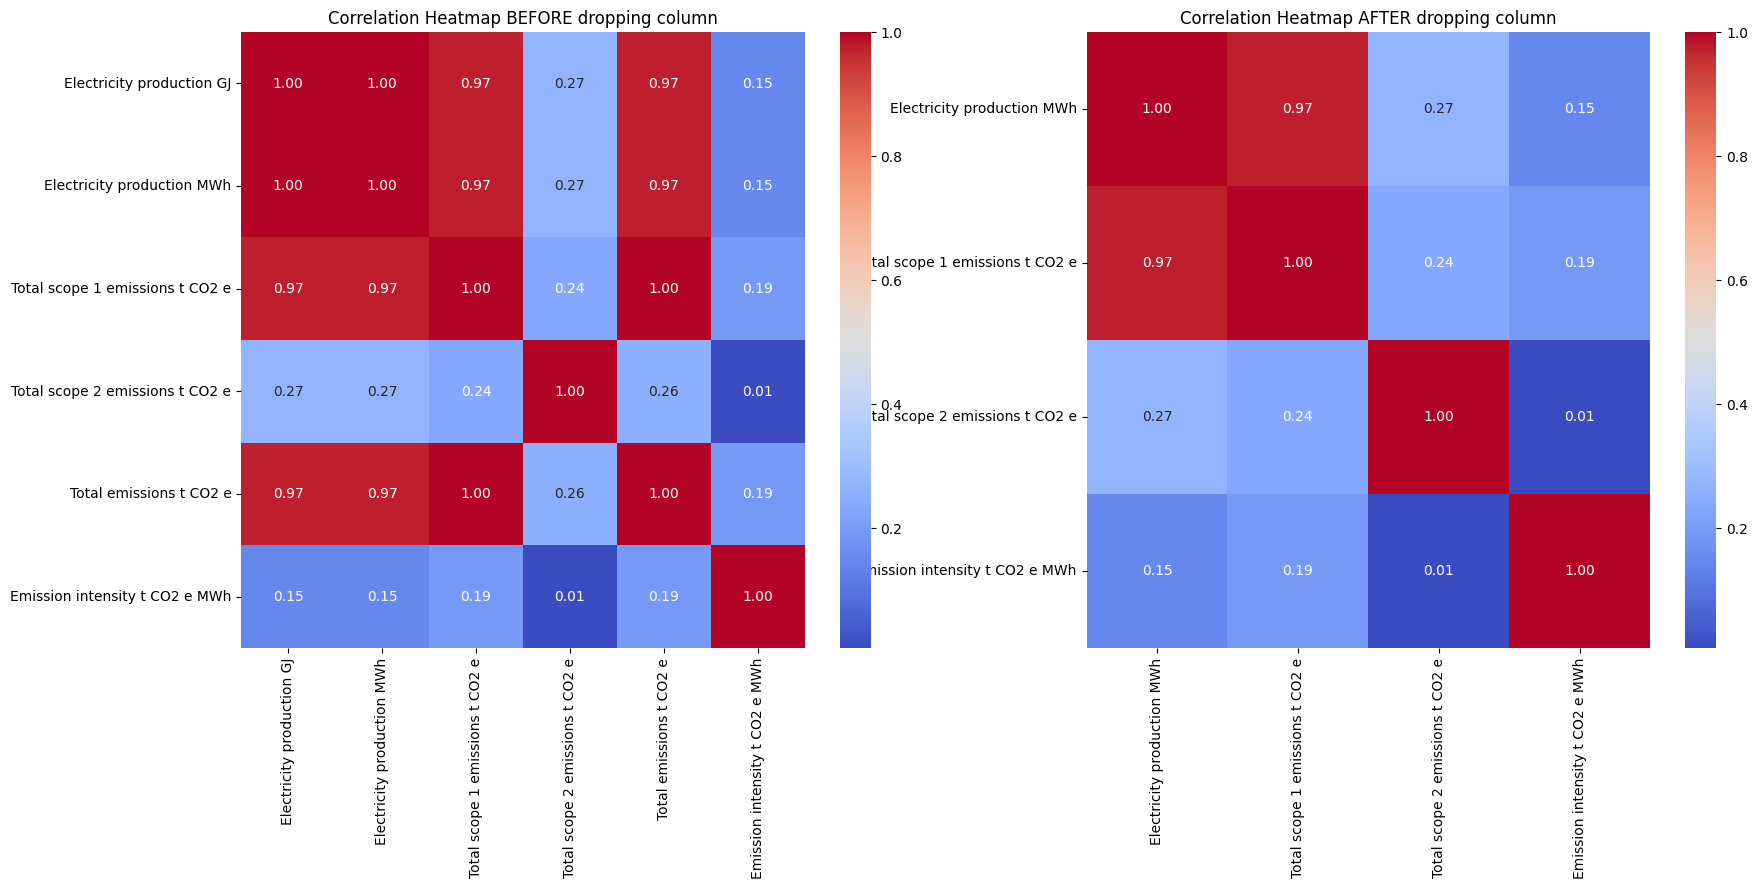

In [271]:
retrieve_data_set()
cleaning_cer()

<h1>Data Integration and Cleaning Data </h1>

In [272]:


# second url file
df_cer_1_approved = pd.read_csv("power-stations-and-projects-accredited.csv")
df_cer_1_commited = pd.read_csv("power-stations-and-projects-committed.csv")
df_cer_1_probable = pd.read_csv("power-stations-and-projects-probable.csv")

# third url file
df_abs = pd.ExcelFile("14100DO0003_2011-24.xlsx")
statistical_area = pd.read_excel(df_abs, 'Table 1', header=[5,6])
lga_area = pd.read_excel(df_abs, 'Table 2', header=[5,6])





#### Cleaning Data Set

In [273]:
cleaning_data.replacing_value(df_cer_1_approved, '-', np.nan)

df_cer_1_approved["power_station_name_clean"] = df_cer_1_approved["Power station name"].apply(cleaning_data.clean_power_name)

df_cer_1_approved.to_csv("output2.csv")

In [274]:
cleaning_data.replacing_value(df_cer_1_commited, '-', np.nan)

cleaning_data.show_null_data(df_cer_1_commited)

Total Duplicated Count:  0


,Null Total Count,Null Percentage
Project Name,0,0.0%
State,0,0.0%
MW Capacity,0,0.0%
Fuel Source,0,0.0%
Committed Date (Month/Year),0,0.0%


In [275]:
cleaning_data.replacing_value(df_cer_1_probable, '-', np.nan)
cleaning_data.show_null_data(df_cer_1_probable)

Total Duplicated Count:  0


,Null Total Count,Null Percentage
Project Name,0,0.0%
State,0,0.0%
MW Capacity,0,0.0%
Fuel Source,0,0.0%


In [276]:
category_question = defaultdict(list)
for cat, q in statistical_area.columns:
    category_question[cat].append(q)
category_question = dict(category_question)

In [277]:
# only get the important rows
statistical_area = statistical_area.iloc[:-7]
lga_area = lga_area.iloc[:-7]

In [278]:
cleaning_data.replacing_value(statistical_area, '-', np.nan)

statistical_area[("Unnamed: 2_level_0", "Year")] = pd.to_numeric(statistical_area[("Unnamed: 2_level_0", "Year")], errors="coerce").astype("Int64") 
statistical_area.head()

/var/folders/2h/b49chrcn56z4tf_5y0zw27740000gn/T/ipykernel_41225/3408484460.py:221: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(existing_value, new_value, inplace=True)


Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0  \
                Code              Label               Year   
0                AUS          Australia               2011   
1                AUS          Australia               2016   
2                AUS          Australia               2017   
3                AUS          Australia               2018   
4                AUS          Australia               2019   

   Number of businesses - at 30 June  \
  Number of non-employing businesses   
0                                NaN   
1                                NaN   
2                                NaN   
3                                NaN   
4                                NaN   

                                                 \
  Number of employing businesses: 1-4 employees   
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                                           NaN   

                                                  \
  Number of employing businesses: 5-19 employees   
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   

                                                        \
  Number of employing businesses: 20 or more employees   
0                                                NaN     
1                                                NaN     
2                                                NaN     
3                                                NaN     
4                                                NaN     

                                Business entries - year ended 30 June  \
  Total number of businesses Number of non-employing business entries   
0                        NaN                                      NaN   
1                        NaN                                      NaN   
2                        NaN                                      NaN   
3                        NaN                                      NaN   
4                        NaN                                      NaN   

                                                       ...  \
  Number of employing business entries: 1-4 employees  ...   
0                                                NaN   ...   
1                                                NaN   ...   
2                                                NaN   ...   
3                                                NaN   ...   
4                                                NaN   ...   

  Estimated dwelling stock - as at June quarter                               \
                           Houses - total (no.) Townhouses - additions (no.)   
0                                           NaN                          NaN   
1                                           NaN                          NaN   
2                                     7279135.0                      31729.0   
3                                     7371408.0                      33346.0   
4                                     7472853.0                      32571.0   

                                                        \
  Townhouses - removals (no.) Townhouses - total (no.)   
0                         NaN                      NaN   
1                         NaN                      NaN   
2                       480.0                1261457.0   
3                       919.0                1293884.0   
4                       712.0                1325743.0   

                                                            \
  Apartments - additions (no.) Apartments - removals (no.)   
0                          NaN                         NaN   
1                          NaN                         

In [279]:
cleaning_data.replacing_value(lga_area, '-', np.nan)

lga_area[("Unnamed: 2_level_0", "Year")] = pd.to_numeric(lga_area[("Unnamed: 2_level_0", "Year")], errors="coerce").astype("Int64") 
lga_area.head()

/var/folders/2h/b49chrcn56z4tf_5y0zw27740000gn/T/ipykernel_41225/3408484460.py:221: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(existing_value, new_value, inplace=True)


Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0  \
                Code              Label               Year   
0              10050             Albury               2011   
1              10050             Albury               2016   
2              10050             Albury               2017   
3              10050             Albury               2018   
4              10050             Albury               2019   

   Number of businesses - at 30 June  \
  Number of non-employing businesses   
0                                NaN   
1                                NaN   
2                                NaN   
3                                NaN   
4                                NaN   

                                                 \
  Number of employing businesses: 1-4 employees   
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                                           NaN   

                                                  \
  Number of employing businesses: 5-19 employees   
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   

                                                        \
  Number of employing businesses: 20 or more employees   
0                                                NaN     
1                                                NaN     
2                                                NaN     
3                                                NaN     
4                                                NaN     

                                Business entries - year ended 30 June  \
  Total number of businesses Number of non-employing business entries   
0                        NaN                                      NaN   
1                        NaN                                      NaN   
2                        NaN                                      NaN   
3                        NaN                                      NaN   
4                        NaN                                      NaN   

                                                       ...  \
  Number of employing business entries: 1-4 employees  ...   
0                                                NaN   ...   
1                                                NaN   ...   
2                                                NaN   ...   
3                                                NaN   ...   
4                                                NaN   ...   

  Industry of employment - Persons aged 15 years and over - Census  \
                       Rental, hiring and real estate services (%)   
0                                                1.3                 
1                                                1.3                 
2                                                NaN                 
3                                                NaN                 
4                                                NaN                 

                                                       \
  Professional, scientific and technical services (%)   
0                                                4.5    
1                                                4.3    
2                                                NaN    
3                                                NaN    
4                                                NaN    

                                           \
  Administrative and support services (%)   
0                                     2.8   
1                                     3.0   
2                                     NaN   
3                                     NaN   
4                                     NaN   

  

### Data Augmentation

In [280]:

load_dotenv()

# Initialize Google API
API_KEY = os.getenv("GOOGLE_MAPS_API_KEY")
#geo_api = GeoAPI(API_KEY)

# # Geocode DataFrame
#df_geo = geo_api.geocode_dataframe(df_cer_1_approved, ["power_station_name_clean", "Postcode","State"])
df_geo = pd.read_csv("output4.csv")
print(df_geo)



     Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0 Accreditation code  \
0               0             0             0           0           SRPXQLE8   
1               1             1             1           1           SRPYNS39   
2               2             2             2           2           SRPYNS58   
3               3             3             3           3           SRPXVCN4   
4               4             4             4           4           SRPXQLF9   
..            ...           ...           ...         ...                ...   
275           275           275           275         275           SRPXVCT8   
276           276           276           276         276           SRPXQLM5   
277           277           277           277         277           SRPXVCP9   
278           278           278           278         278           SRPVWAN8   
279           279           279           279         279           SRPYNSE3   

                                    Pow

In [281]:
df_geo = df_geo.copy()

for col in df_geo.columns:
    if df_geo[col].apply(lambda x: isinstance(x, list)).any():
        df_geo[col] = df_geo[col].apply(lambda x: ','.join(x) if isinstance(x, list) else x)

def is_valid(place_types):
    types = [t.strip() for t in place_types.split(',')]
    return 'Valid' if 'establishment' in types or 'point_of_interest' in types else 'Not Valid'

# Apply function
df_geo['valid_flag'] = df_geo['Place_Types'].apply(is_valid)



In [282]:
df_geo.to_csv("output4.csv")

In [284]:
statistical_area['Unnamed: 3_level_0','State'] = statistical_area['Unnamed: 0_level_0','Code'].apply(cleaning_data.map_state)

statistical_area = statistical_area.drop(columns=[("Number of businesses - at 30 June", "Total number of businesses")])
lga_area['Unnamed: 3_level_0','State'] = lga_area['Unnamed: 0_level_0','Code'].apply(cleaning_data.map_state)



/var/folders/2h/b49chrcn56z4tf_5y0zw27740000gn/T/ipykernel_41225/2654051777.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lga_area['Unnamed: 3_level_0','State'] = lga_area['Unnamed: 0_level_0','Code'].apply(cleaning_data.map_state)


#### Process Creating Schema in Duck DB

In [333]:
# module related for database
database = ConnectDB("mydatabase.duckdb")

column_state = ['state_code', 'name']

state_abbrev = {
    "NSW": "New South Wales",
    "VIC": "Victoria",
    "QLD": "Queensland",
    "SA": "South Australia",
    "WA": "Western Australia",
    "TAS": "Tasmania",
    "NT": "Northern Territory",
    "ACT": "Australian Capital Territory",
    "OTH": "Other Territories",
    "AUS": "Australia"
}

column_states = ['states_id', 'states']

column_name_facility = ['facility_id', 'states_id', 'facility_name', 'postcode', 'source']


column_names_power_stations = ['id', 'accreditation_code', 'power_station_name','state','postcode',
                               'capacity_mw','source', 'accreditation_start_date','approval_date','commited_date','status']

df_states = pd.DataFrame(list(state_abbrev.items()), columns=["state_code", "name"])



database.create_table(df = df_states, table_name="states", primary_key="state_code", foreign_keys=None)
database.insert_data(df=df_states, table_name="states", column_map={"state_code":"state_code", "name":"name"})





Executing SQL:
 CREATE TABLE IF NOT EXISTS states (
    "state_code" VARCHAR,
    "name" VARCHAR,
    PRIMARY KEY("state_code")
);
Table 'states' created successfully.
Error inserting data: Constraint Error: Duplicate key "state_code: NSW" violates primary key constraint.
